# Simulate loan approval decisions 

## Get the power of big simulations to build trust in your decision automation with IBM Cloud Pak for Business Automation

This notebook shows the exploitation of a loan approval dataset automated by IBM Cloud Pak for Business Automation. More precisely we apply <b>Operational Decision Manager</b> to model a decision service and deploy it as a rest endpoint. From there we use a simulation microservice project to generate analytical notebooks to get insights for the decision automation.

In this approach we dive into the automated decision dataset. For each decision we captured the request with all input parameters, the answer with all output parameters computed by the decision logic, and the trace. In the trace you find the list of the executed rules and ruleflows.

In [1]:
# Import libs
from faker import Faker

from pathlib import Path 

import json

import os

import pandas as pd 
import numpy as np

from tqdm import tqdm

import plotly
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.express as px
init_notebook_mode(connected = True)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pyspark.sql import SparkSession
from pyspark import SparkContext

## 1 - Read the decision dataset
This notebook post-processes the result of a simulation that wrote a dataset of automated decisions in a data lake or a local file system. The first decisions found in the simulation dataset look like below:

In [2]:
datasinkPath = "../../data/ODM/loanvalidation/odm-22.0.1-miniloan-decisions-withtrace-20220721_133323-5K.json" #startSimulation.json()["dataSink"]["uri"]

#df = pd.read_csv("https://raw.githubusercontent.com/ODMDev/decisions-analytics/master//data/ODM/loanvalidation/odm-22.0.1-miniloan-decisions-withtrace-20220721_133323-5K.json")

outputData = []
if os.path.exists(datasinkPath):
    with open(datasinkPath) as file:
        filesize = os.path.getsize(datasinkPath)
        if filesize == 0:
            print("The file {} is empty".format(datasinkPath))
        else:
            while (line := file.readline().rstrip()):
                jsonLine = dict()
                jsonLine["request"] = json.loads(line)["request"]
                jsonLine["trace"] = json.loads(line)["trace"]
                jsonLine["response"] = json.loads(line)["response"]

                outputData.append(jsonLine)

datasink = pd.json_normalize(outputData)
#datasink = pd.json_normalize(outputData, ["taskInformation", "ruleInformation"], ["totalTasksNotExecuted", "shortname", ["tasksNotExecuted", "taskInformation"]])
datasink.head(5)

,request.loan.duration,request.loan.amount,request.loan.yearlyInterestRate,request.loan.yearlyRepayment,request.borrower.creditScore,request.borrower.name,request.borrower.yearlyIncome,request.__TraceFilter__.infoExecutionEventsAsked,request.__TraceFilter__.infoTasks,request.__TraceFilter__.infoExecutionDuration,...,trace.outputParameters.loan.messages,trace.outputParameters.loan.yearlyInterestRate,trace.outputParameters.loan.yearlyRepayment,response.loan.duration,response.loan.amount,response.loan.approved,response.loan.messages,response.loan.yearlyInterestRate,response.loan.yearlyRepayment,response.__DecisionID__
0,162,783440,0.030005,70648,736,Stephanie Roberts,113243,False,False,True,...,"[Too big Debt-To-Income ratio, debt-to-income ...",0.030005,70648,162,783440,False,"[Too big Debt-To-Income ratio, debt-to-income ...",0.030005,70648,7458b498-abc1-44ef-8138-790dd4583fdb0
1,183,1787385,0.054819,173197,527,Julie Harris,224186,False,False,True,...,"[The loan cannot exceed 1,000,000]",0.054819,173197,183,1787385,False,"[The loan cannot exceed 1,000,000]",0.054819,173197,e21d78c2-5671-4126-94cc-b161ff771cf10
2,75,1733494,0.055183,328563,460,Andre Cohen,39954,False,False,True,...,"[The loan cannot exceed 1,000,000]",0.055183,328563,75,1733494,False,"[The loan cannot exceed 1,000,000]",0.055183,328563,5280c86e-4b3c-499c-885f-ef1b3eaadb290
3,72,1350004,0.043400,255970,751,April Grimes,219998,False,False,True,...,"[The loan cannot exceed 1,000,000]",0.043400,255970,72,1350004,False,"[The loan cannot exceed 1,000,000]",0.043400,255970,a899017e-4a2a-4de7-a880-680f3c97d96d0
4,160,1210944,0.037772,115742,684,Stephen Gonzales,72470,False,False,True,...,"[The loan cannot exceed 1,000,000]",0.037772,115742,160,1210944,False,"[The loan cannot exceed 1,000,000]",0.037772,115742,1e7015c3-d8a0-48f5-8359-39a13e4d37f40


Prepare visualization elements in Plotly

In [3]:
import plotly
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected = True)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pgeocode

#Graph configs
approval_colors = ["#00CC96", "#FF6692"]
color_indices = [0, 1]

pie_chart_approval_loan_names = ['approved', 'rejected']
pie_chart_loan_amount_names = ['approved amount', 'rejected amount']
bidirectional_bar_chart_label_v2=['number of applications', 'sum of applications amounts']
bidirectional_bar_chart_label=['number of applications', 'sum of applications amounts']
bidirectional_bar_chart_label=['number of rejected applications', 'sum of rejected applications amounts', 'number of approved applications', 'sum of approved applications amounts']
radar_chart_labels=['number of rejected applications', 'sum of rejected applications amounts', 'number of approved applications', 'sum of approved applications amounts', 'ratio approved/requested']

## 2 - Business Metrics
From each raw decision we extract or compute a set of metrics. The ratio of accepted versus rejected applications is a metric. All raw input and output metrics are eligible to be metrics. Main metrics used in this report are:
* accepted/rejected status,
* loan amount,
* borrower's credit score,
* borrower's yearly income

In [4]:
########### ODM #############
select_approved_decision = '`response.loan.approved` == True'
select_rejected_decision = '`response.loan.approved` == False'

get_decision_approval = 'response.loan.approved'
get_decision_amount = 'response.loan.amount'
get_decision_borrower_yearly_income = 'request.borrower.yearlyIncome'
get_decision_borrower_credit_score = "request.borrower.creditScore"
get_decision_id = 'response.__DecisionID__'
get_decision_reimbursement_rate = 'response.loan.yearlyInterestRate'
get_decision_yearly_repayment = 'response.loan.yearlyRepayment'

## 3 - Business KPIs
Key Performance Indicators are aggregated counters to judge the decision set. Examples of basic KPIs for loan approval are:
- Sum of approved applications / total number of applications
- Sum of rejected applications / total number of applications
- Total of approved loan amounts
- Total of rejected loan amounts

Only limits are the imagination and computational power of Python, Scala or R languages.

In [5]:
########### KPIs #############
approved_loan = datasink.query(select_approved_decision)
rejected_loan = datasink.query(select_rejected_decision)

########### Approved/Rejected PRINT #############
print("Number of approved loan request = ", approved_loan.shape[0])
print("Number of rejected loan request = ", rejected_loan.shape[0])
print("Rate of approval = ", approved_loan.shape[0]/datasink.shape[0])

print("Total approved amount = ",datasink.query(select_approved_decision)[get_decision_amount].sum())
print("Total rejected amount = ",datasink.query(select_rejected_decision)[get_decision_amount].sum())
print("Total requested amount = ",datasink[get_decision_amount].sum())

Number of approved loan request =  1087
Number of rejected loan request =  3913
Rate of approval =  0.2174
Total approved amount =  366173820
Total rejected amount =  4676578568
Total requested amount =  5042752388


## 4 - Visualization
### 4.1 - Approval vs Rejection
We use donut representations to get an overview of the acceptation of the loans, in terms of number of applications and loan amounts:
   * the first to measure the accept rate and number
   * the second to measure the total amount of accepted versus rejected loan applications

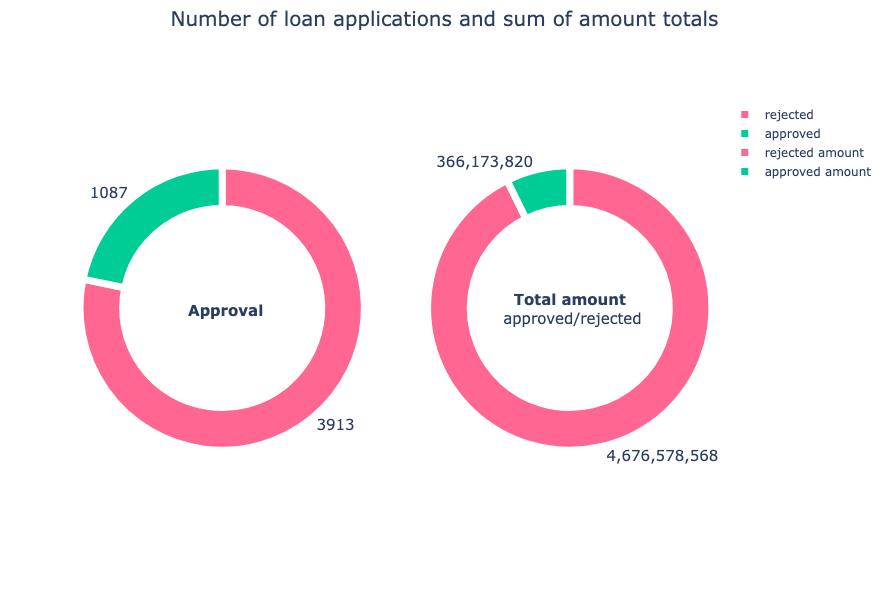

In [6]:
########### settings ###########
donut_hole = 0.7

########### Approved/Rejected PIE CHART #############
trace_approval = go.Pie(labels = pie_chart_approval_loan_names,
                            values = [approved_loan.shape[0], rejected_loan.shape[0]],
                            hole = donut_hole)

########### Approved/Rejected Amount PIE CHART #############
trace_amount = go.Pie(values= [datasink.query(select_approved_decision)[get_decision_amount].sum(),
                                 datasink.query(select_rejected_decision)[get_decision_amount].sum()],
                            labels=pie_chart_loan_amount_names,
                            hole = donut_hole,
                            name="Loan amount")

fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]],
                    column_widths=[0.5, 0.5],
                    #vertical_spacing=0.001,
                    subplot_titles=("Approval", "Approved/rejected amount")
                    )

fig.add_trace(trace_approval, row=1, col=1)
fig.add_trace(trace_amount, row=1, col=2)

fig.update_traces(hoverinfo='label', textinfo='value', textfont_size=15, textposition="outside",
                  marker=dict(colors=approval_colors, line=dict(color='#FFFFFF', width=7)))
                
fig.update_annotations(yshift=20) # subplot tiltes

fig.update_layout(
    barmode='stack',
    plot_bgcolor = "white",
    #paper_bgcolor = 'lightgray',
    height=600,
    title={'text': f"Number of loan applications and sum of amount totals",
          'x':0.5,
          'y':0.98,
          'xanchor': 'center',
          'font_size': 20
    },
    annotations= [
         {
            "font": {
               "size": 15
            },
            "showarrow": False,
            "text": "<b>Approval</b>",
            "x": 0.23,
            "y": 0.42
         },
         {
            "font": {
               "size": 15
            },
            "showarrow": False,
            "text": "<b>Total amount</b><br> approved/rejected",
            "x": 0.775,
            "y": 0.4
         }
      ],
      )

iplot(fig)

### 4.2 - Represent the decisions in a yearly income, loand amount, and approval outcome space
We leverage a scatter component to represent all decisions. Each decision is colored in pink if refused or green if accepted. The circle radius depends on the amount. You can zoom in, select one decision, and get a tooltip with a summary of the decision.

We added 2 lines in the view:
- one horizontal line that matches a business rule that rejectsany application with a loan amount greater than 1 M.
- one diagonal that separates the population of never accepted application from one where accepted applications are concentrated. This observation is consistent with busines rules that enforced a maximum income/reimbursement ratio.

In [7]:
def array_normalize(values, max_value=1):
    normalized_values = []
    for value in values:
        normalized_values.append((value*max_value)/max(values))
    return normalized_values

def set_colors(values, true_color="#00CC96", false_color="#FF6692"):
    colors = []
    for value in values:
        if(value): 
            colors.append(true_color) 
        else: 
            colors.append(false_color) 
    return colors

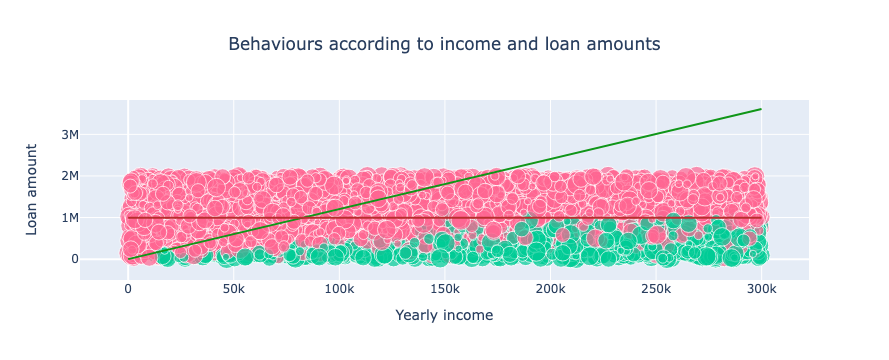

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                 x=datasink[get_decision_borrower_yearly_income],
                 y=datasink[get_decision_amount],
                 mode='markers',
                 marker_size=array_normalize(datasink[get_decision_borrower_credit_score], 20), 
                 marker_color=set_colors(datasink[get_decision_approval]),
                 text=datasink[get_decision_approval], 
                 hovertext=datasink[get_decision_id],
                 hovertemplate="<b>Income:</b> %{x}<br><b>Loan amount:</b> %{y}<br><b>Approval:</b> %{text}<br><b>Id:</b> %{hovertext}<extra></extra>",
                 name='V1'
))


fig.add_trace(
    go.Scatter(
        x=np.array([0, max(datasink[get_decision_borrower_yearly_income])]),
        y=max(datasink.query(select_approved_decision)[get_decision_amount]/datasink.query(select_approved_decision)[get_decision_borrower_yearly_income])*np.array([0, max(datasink[get_decision_borrower_yearly_income])]),
        mode="lines",
        line=go.scatter.Line(color="#109618"),
        showlegend=False)
)
fig.add_trace(
    go.Scatter(
        x=np.array([0, max(datasink[get_decision_borrower_yearly_income])]),
        y=max(datasink.query(select_approved_decision)[get_decision_amount])*np.array([1, 1]),
        mode="lines",
        line=go.scatter.Line(color="#B82E2E"),
        showlegend=False)
)


fig.update_xaxes(title_text='Yearly income')
fig.update_yaxes(title_text='Loan amount')

fig.update_layout(
    barmode='stack', 
    showlegend=False,
    title={'text': f"Behaviours according to income and loan amounts",
          'x':0.5,
          'xanchor': 'center'
    })

iplot(fig)

You can zoom in and out in the graphic. A sticker pops up when the mouse stops on a decision.

We draw 2 lines to check that decision points comply with the business logic implemented in the decision service:
- one line representing f(x)=x*0.3 is about the max debt income ratio max to accept an application
- one line for f(x)= 1M income to show the max limit to accept loan applications as stated in the business logic of this sample.
You can ckeck visualy that all accepted (green) decisions are under these 2 maximum lines.

### 4.3 - Represent decisions according yearly income and credit score
We use a scatter view to represent the decisions this time with yearly income and credit score. We observe 2 gradients that cumulate their effects:

the higher yearly income is the more likelyhood to get the loan accepted
the higher is the credit score the more likelyhood to get the loan accepted

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                 x=datasink[get_decision_borrower_yearly_income]/12,
                 y=datasink[get_decision_yearly_repayment],
                 mode='markers',
                 marker_size=array_normalize(datasink[get_decision_borrower_credit_score], 20), 
                 marker_color=set_colors(datasink[get_decision_approval]),
                 text=datasink[get_decision_approval], 
                 hovertext=datasink[get_decision_id],
                 hovertemplate="<b>Income:</b> %{x}<br><b>Repayment:</b> %{y}<br><b>Approval:</b> %{text}<br><b>Id:</b> %{hovertext}<extra></extra>",
                 name='V1'
))

pente1 = max(datasink.query(select_approved_decision)[get_decision_yearly_repayment]*12/datasink.query(select_approved_decision)[get_decision_borrower_yearly_income])
fig.add_trace(
    go.Scatter(
        x=np.array([0, max(datasink[get_decision_borrower_yearly_income]/12)]),
        y=pente1*np.array([0, max(datasink[get_decision_borrower_yearly_income]/12)]),
        mode="lines",
        line=go.scatter.Line(color="#109618"),
        showlegend=False)
)
fig.add_trace(
    go.Scatter(
        x=np.array([0, max(datasink[get_decision_borrower_yearly_income]/12)]),
        y=max(datasink.query(select_approved_decision)[get_decision_yearly_repayment])*np.array([1, 1]),
        mode="lines",
        line=go.scatter.Line(color="#B82E2E"), ##B82E2E
        showlegend=False)
)

print("Rate : ",pente1)

Rate :  3.597101478816539


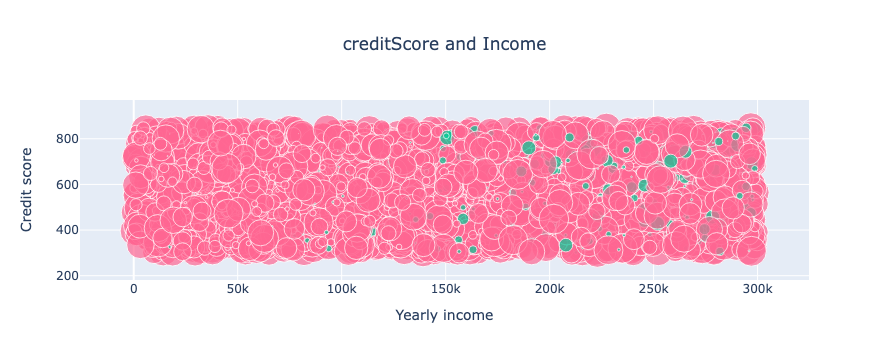

In [10]:
############ SCATTER CHART #############
fig = go.Figure()
max_marker_size = 30
fig.add_trace(go.Scatter(
                 x=datasink[get_decision_borrower_yearly_income],
                 y=datasink[get_decision_borrower_credit_score],
                 mode='markers',
                 marker_size=array_normalize(datasink[get_decision_amount], max_marker_size), 
                 marker_color=set_colors(datasink[get_decision_approval]),
                 text=datasink[get_decision_approval], 
                 hovertemplate="<b>Income:</b> %{x}<br><b>creditScore:</b> %{y}<br><b>Approval:</b> %{text}<extra></extra>",
                 name='V1'
))

fig.update_xaxes(title_text='Yearly income')
fig.update_yaxes(title_text='Credit score')

fig.update_layout(
    barmode='stack', 
    showlegend=False,
    title={'text': f"creditScore and Income",
          'x':0.5,
          'xanchor': 'center'
    })

iplot(fig)

### 4.4 - Visualize multiple business KPIs
We use a radar (named too as Kiviat diagram or spyder) to represent the relative performances of the decision set.

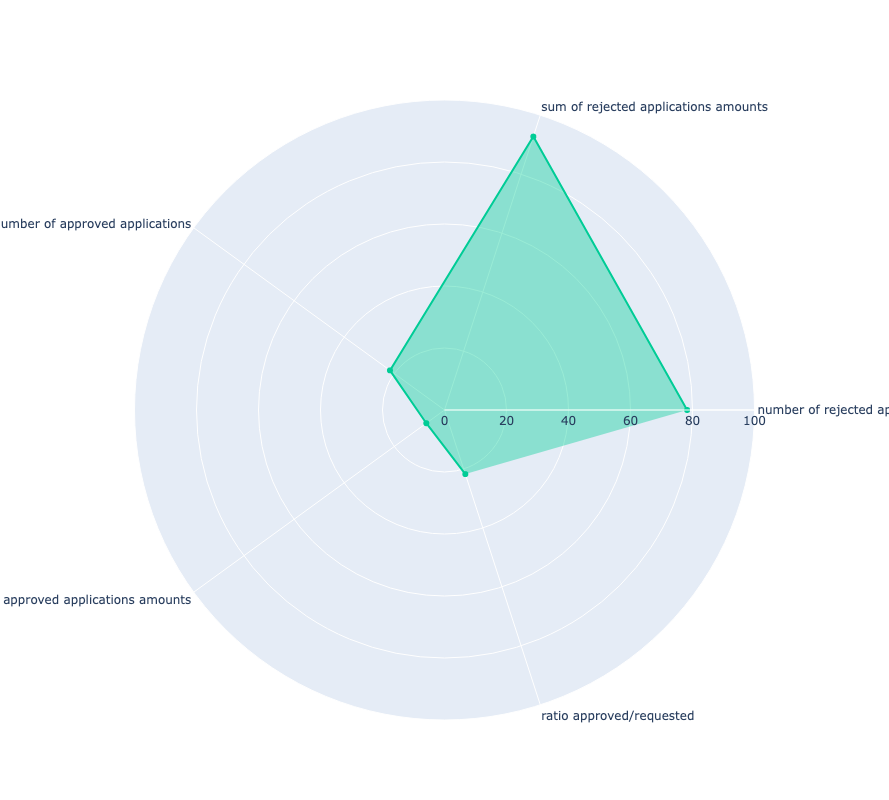

In [11]:
fig = go.Figure()

#radar dimension normalization 
radar_max_value = 100

values = np.array([[datasink.query(select_rejected_decision).shape[0], 
                    datasink.query(select_rejected_decision)[get_decision_amount].sum(), 
                    datasink.query(select_approved_decision).shape[0], 
                    datasink.query(select_approved_decision)[get_decision_amount].sum(), 
                    datasink.query(select_approved_decision).shape[0]/(datasink.query(select_approved_decision).shape[0]+datasink.query(select_rejected_decision).shape[0])
                   ],
                   [
                    datasink.shape[0],
                    datasink[get_decision_amount].sum(),
                    datasink.shape[0],
                    datasink[get_decision_amount].sum(),
                    1
                   ]
                  ])
normed_values = (values*radar_max_value) / values.max(axis=0)

def radar_normalization(values, max_value):
    normalized_values = []
    for value in values:
        normalized_values.append((value*max_value)/max(values))
    return normalized_values

fig.add_trace(go.Scatterpolar(
      r=normed_values[0],
      theta=radar_chart_labels,
      marker_color='rgb(0,204,150)',
      fillcolor='rgba(0,204,150,0.4)',
      fill='toself',
      name='V1',
))

fig.update_layout(
  height=800,
  polar=dict(
    #bgcolor= 'rgb(239, 239, 232)',
    radialaxis=dict(
      visible=True,
      range=[0, radar_max_value],
      #linecolor='red',
      #gridcolor='red',
      #axiscolor='red',
      #tickcolor='red',
    )),
  #showlegend=False
)

fig.show()

### 4.5 - Apply Violins to compare distributions between accepted and rejected applications

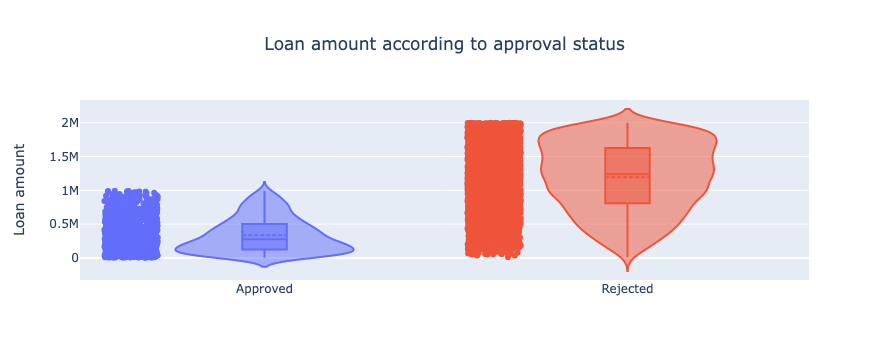

In [12]:
subplot_titles = ['Approved', 'Rejected']
select_decision_approval_status = [select_approved_decision, select_rejected_decision]
get_decision_value = [get_decision_amount, get_decision_amount]
fig = go.Figure()
for idx, approval in enumerate(select_decision_approval_status):
    fig.add_trace(go.Violin(y=datasink.query(approval)[get_decision_amount],
                            name=subplot_titles[idx],
                            box_visible=True,
                            meanline_visible=True,
                            points='all'
                            ))

fig.update_yaxes(title_text='Loan amount')

fig.update_layout(
    barmode='stack', 
    showlegend=False,
    title={'text': f"Loan amount according to approval status",
          'x':0.5,
          'xanchor': 'center'
    })

fig.show()

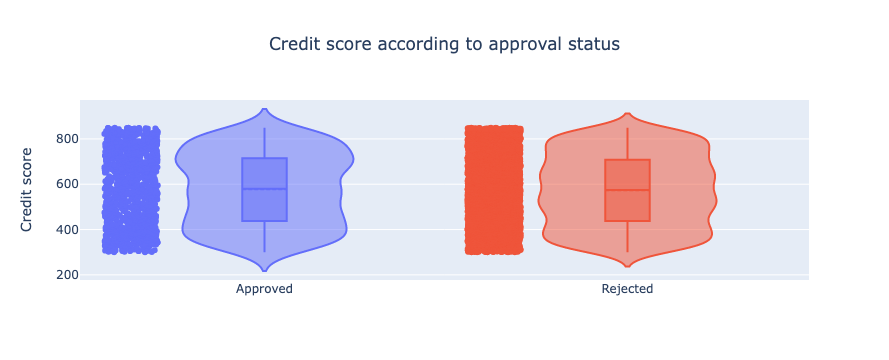

In [13]:
subplot_titles = ['Approved', 'Rejected']
select_decision_approval_status = [select_approved_decision, select_rejected_decision]
get_decision_value = [get_decision_amount, get_decision_amount]
fig = go.Figure()
for idx, approval in enumerate(select_decision_approval_status):
    fig.add_trace(go.Violin(y=datasink.query(approval)[get_decision_borrower_credit_score],
                            name=subplot_titles[idx],
                            box_visible=True,
                            meanline_visible=True,
                            points='all'
                            ))

fig.update_yaxes(title_text='Credit score')

fig.update_layout(
    barmode='stack', 
    showlegend=False,
    title={'text': f"Credit score according to approval status",
          'x':0.5,
          'xanchor': 'center'
    })

fig.show()

## 5 - Go inside the decisions
We exploit the trace in each of the decision to extract how their outcome was computed. We get the executed and we aggregate them to understand their coverage for this decision set.

### 5.1 - Compute an execution statistic table for all business rules

In [14]:
rules = []
rules_counter = dict()

for number_of_decision in range(0,len(outputData)):

    if 'ruleInformation' in outputData[number_of_decision]['trace']['rulesFired']:
        executed_rules = outputData[number_of_decision]['trace']['rulesFired']['ruleInformation']
        rules.extend(executed_rules)

        for executed_rule in executed_rules: 
            if executed_rule['name'] in rules_counter:
                rules_counter[executed_rule['name']] += 1
            else :
                rules_counter[executed_rule['name']] = 1

    if 'ruleInformation' in outputData[number_of_decision]['trace']['rulesNotFired']:
        not_executed_rules = outputData[number_of_decision]['trace']['rulesNotFired']['ruleInformation']

        for not_executed_rule in not_executed_rules: 
            if not_executed_rule['name'] not in rules_counter:
                rules_counter[not_executed_rule['name']] = 0


rules_coverage = pd.DataFrame(rules_counter.items(), columns=['Rule', 'Count'])
rules_coverage['Percentage']= (rules_coverage['Count']*100)/datasink.shape[0]

rules_coverage

,Rule,Count,Percentage
0,eligibility.minimum_income,1394,27.88
1,eligibility.repayment_and_score_6,889,17.78
2,eligibility.repayment_and_score_0,0,0.00
3,eligibility.minimum_credit_score,0,0.00
4,validation.maximum_amount,2519,50.38
5,eligibility.repayment_and_score_2,59,1.18
6,eligibility.repayment_and_score_4,34,0.68


### 5.2 - Compute coverage rate for rule execution
This view show all executed rules with its execution percentage. 100% means that the rule has been executed in all decisions. The rule coverage empowers business users to check if the statistics of rule execution match their expectations and hypothesis when applied to the applications, and data in general.

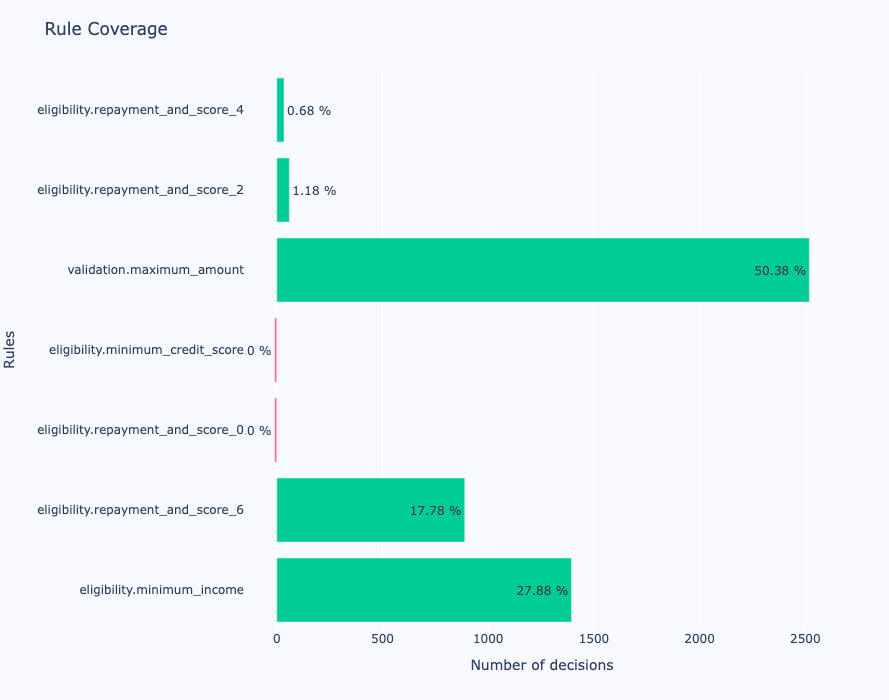

In [15]:
fig = go.Figure(go.Bar(
            x=[-10 if count==0 else count for count in rules_coverage['Count']],
            y=rules_coverage["Rule"],
            text=[f'------> {item} %' if item==0.00 else f'{item} %' for item in rules_coverage['Percentage']],
            #text=['{:.2f} %'.format(item) for item in rules_coverage['Percentage']], 
            marker_color=[px.colors.qualitative.Plotly[6] if item<=0 else px.colors.qualitative.Plotly[2] for item in rules_coverage['Percentage']],
            #textposition="inside",
            hovertemplate="<b>%{y}</b><br><b>Count:</b> %{x}<br><b>Percentage:</b> %{text}<extra></extra>",
            orientation='h'))

fig.update_xaxes(title_text='Number of decisions')
fig.update_yaxes(title_text='Rules')

fig.update_layout(
    title='Rule Coverage',
    legend=dict(x=0.029, y=1.038, font_size=10),
    margin=dict(l=100, r=50, t=70, b=70),
    height=700,
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)
fig.show()

## Conclusion
This notebook shows a business report to analyze a volume of loan approval decisions. It leverages automated decisions performed by IBM Cloud Pak for Business Automation and more precisely Operational Decision Manager. This report has been generated by the SimuLatte project that takes care of the simulation and the run of analytics report templates.

Tiémoko Dembele and Pierre Feillet are members of IBM France lab and developping actively the SimuLatte project to empower simulations for business automation.